ДЗ по итогам лекции 12.

ДЗ - в рамках ранее выполненной работы по обработке данных c помощью pandas (учебный файл с данными credit_train.csv), выполнить все работы с пандас дата фреймом через SQL запросы. 
- разбить выборку на обучающую и тестовую
- проанализировать пропуски и решить, что с ними делать
- проанализировать выбросы
- создать/ удалить переменные
- закодировать категориальные переменные
- нормализовать числовые переменные (при необходимости)


Сама эта ранее выполненная работа включала следующие задания
credit_train.csv - файл данных
Подготовить данные для модели:
    
Анализ данных, необходимые корректировки. 
1. Обработать пропуски. 
2. Оценить выбросы. 
3. Корреляция. 
4. Тест на нормальность распределения.
5. Масштабировать данные.

В прошлый раз проделывалось следующее: после загрузки файла данных, представленного в формате csv, в датафрейм модуля pandas.
*) Далее следует провести поиск пропусков и удалить строки с пропусками.
*) Кроме того, предварительный анализ файла данных показывает, что колонка living region содержит много дублей типа "московская обл" и "обл московская" или "чеченская республика" и "чеченская респ". Придется поработать с данными этой колонки, чтобы привести систему обозначений регионов к однозначной. Поскольку регионов слишком много, что затруднит анализ корреляции данных, то мы приведем всю систему к федеральным округам и двум столицам - Москва и Санкт-Петербург.
*) Далее для оценки выбросов числовых данных следует провести оценку матожидания и дисперсии каждого столбца данных, представленного в численном виде. Все значения, отстоящие более чем на 3 выборочных стандартных отклонения, удаляем из массива данных (точнее, удаляем из выборки все объекты, для которых хотя бы в одном столбце имеются выбросы).
*) С помощью функций подключенной библиотек оценим нормальность распределений данных
*) В конце числовые колонки данных масштабируем, поделив на максимальный элемент каждой колонки

Нынче нужно проделать это же задание через SQL запросы.

Загружаем данные.
Выводим для ознакомления заголовочную строку и первые пять строк. 

In [1]:
import pandas as pd
import sklearn as sk
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

data_table = pd.read_csv('credit_train.csv', sep = ';', decimal = ',', encoding = 'windows-1251')
print(f'Rows in the initial table: {len(data_table)}') 
print(f'Initial column number: {data_table.shape[1]}')
print(data_table.head())


Rows in the initial table: 170746
Initial column number: 15
   client_id gender   age marital_status job_position  credit_sum  \
0          1      M   NaN            NaN          UMN    59998.00   
1          2      F   NaN            MAR          UMN    10889.00   
2          3      M  32.0            MAR          SPC    10728.00   
3          4      F  27.0            NaN          SPC    12009.09   
4          5      M  45.0            NaN          SPC         NaN   

   credit_month tariff_id  score_shk education        living_region  \
0            10       1.6        NaN       GRD   КРАСНОДАРСКИЙ КРАЙ   
1             6       1.1        NaN       NaN               МОСКВА   
2            12       1.1        NaN       NaN      ОБЛ САРАТОВСКАЯ   
3            12       1.1        NaN       NaN    ОБЛ ВОЛГОГРАДСКАЯ   
4            10       1.1   0.421385       SCH  ЧЕЛЯБИНСКАЯ ОБЛАСТЬ   

   monthly_income  credit_count  overdue_credit_count  open_account_flg  
0         30000.0       

Видим сразу много NaN. 
Это процедура загрузки так заменила пропуски.
Такие строки подлежат устранению.
Удаляем строки c NaN (то есть с отсутствовавшими изначально значениями, которые при загрузке с помощью функции read_csv превратились в NaN) c помощью dropna:

In [2]:
data_table.dropna(inplace=True) # inplace means we change data_table itself, not create new modified one
print(data_table.head())
print(f'Размер таблицы {data_table.shape}')

    client_id gender   age marital_status job_position  credit_sum  \
7           8      F  26.0            UNM          SPC     47878.0   
9          10      F  32.0            UNM          SPC     26268.0   
10         11      M  26.0            MAR          SPC     16793.0   
12         13      M  37.0            MAR          SPC     42289.0   
13         14      M  43.0            MAR          INP     57567.0   

    credit_month tariff_id  score_shk education        living_region  \
7             10       1.1   0.512525       GRD       МОСКОВСКАЯ ОБЛ   
9             10       1.1   0.465026       GRD  КРАЙ СТАВРОПОЛЬСКИЙ   
10            14       1.0   0.445430       SCH      САНКТ-ПЕТЕРБУРГ   
12            10       1.6   0.691609       SCH    ОБЛ АРХАНГЕЛЬСКАЯ   
13            10       1.1   0.341164       GRD  ХАНТЫ-МАНСИЙСКИЙ АО   

    monthly_income  credit_count  overdue_credit_count  open_account_flg  
7          60000.0           3.0                   0.0                 

Теперь следует обработать колонку living region. 
Поскольку регионов слишком много, работа сразу со всеми даст громоздкие результаты, анализ которых затруднен.
Даже Путину это было ясно еще в 2000 г., отчего вся территория России была им поделена на федеральные округа. 
На данный момент их восемь. Еще имеет смысл отдельно рассматривать Москву и Петербург, поскольку в социологическом плане они сильно отличаются от остальной России.
Поэтому мы объединим все регионы по федеральным округам плюс отдельно укажем Москву и Петербург. 
Получим ровно десять living regions:
1. Центральный ФО
2. Северо-Западный ФО
3. Южный ФО
4. Северо-Кавказский ФО
5. Приволжский  ФО
6. Уральский ФО
7. Сибирский ФО
8. Дальневосточный ФО
9. Москва
10. Санкт-Петербург

С таким количеством регионов уже можно работать.
Попутно отметим, что в таблице два раза встречается регион Россия. Придется его целенаправленно уничтожить.

In [3]:
# looking for the region 'Россия' and removing it:
indices = data_table.index[data_table['living_region'] == 'РОССИЯ']
for ind in indices:
    data_table = data_table.drop(index = ind)

# function returning the string replace_to if a data_cell contains a string from string_set
def replace_cell_value(data_cell, string_set, replace_to):
    for str in string_set:
        if str in data_cell:
            return replace_to            
    return data_cell # if no string in string_set is present in data_cell

# the regions of every federal district, keywords:
central_fo = ['БЕЛГОРОД', 'БРЯНСК', 'ВЛАДИМИР', 'ВОРОНЕЖ', 'ГУСЬ', 'ИВАНОВ', 'КАЛУГ', 'КАЛУЖ', 'КОСТРОМ', 'КУРСК', 'ЛИПЕЦК', 'МОСКОВСК', 'МЫТИЩ', 'ОРЕЛ', 'ОРЁЛ', 'ОРЛОВСК', 'РЯЗАН', 'СМОЛЕНСК', 'ТАМБОВ', 'ТВЕР', 'ТУЛА', 'ТУЛЬСК', 'ЯРОСЛАВ'] 
north_west_fo = ['КАРЕЛ','КОМИ','АРХАНГ','ВОЛОГ','КАЛИНИНГР','ЛЕНИНГР','МУРМАН','НОВГОРОД','ПСКОВ','НЕНЕЦК']
south_fo = ['АДЫГ','КАЛМЫК','КРЫМ','КРАСНОДАР','АСТРАХАН','ВОЛГОГРАД','РОСТОВ','СЕВАСТ']
caucas_fo =['ДАГЕСТ','ИНГУШ','КАБАРДИН','БАЛКАР','КАРАЧАЕВ','ЧЕРКЕС','ОСЕТИ','АЛАНИ','ЧЕЧЕН','ЧЕЧНЯ','СТАВРОПОЛ']
volga_fo = ['ПРИВОЛЖСК','БАШКИР','БАШКОР', 'ГОРЬКИЙ', 'ГОРЬКОВСК', 'МАРИЙ','МОРДОВ','ТАТАР','УДМУРТ','ЧУВАШ','ПЕРМ','КИРОВ','НИЖЕГОРОД','НИЖНИЙ','ОРЕНБУРГ','ПЕНЗ','САМАР','САРАТОВ','УЛЬЯН','СИМБИРС']
urals_fo =['ЕКАТЕРИНБ','СВЕРДЛОВ','КУРГАН','ТЮМЕН','ЧЕЛЯБ','ТАГИЛ','ХАНТЫ','МАНСИ','ЯМАЛ','НЕНЕЦ', '74']
siberia_fo = ['АЛТАЙ','ТЫВА','ТУВА','ТУВИН','ХАКАС','КРАСНОЯРСК','ИРКУТСК','КЕМЕРОВ','КУЗБАСС','НОВОСИБ','ОМСК', 'ЭВЕНК']
far_east_fo = ['ВЛАДИВОСТ','ХАБАРОВ','БУРЯТ','САХА','ЯКУТ','БАЙКАЛ','КАМЧАТ','ПРИМОРСК','АМУР','МАГАДАН','САХАЛИН','ЕВРЕЙ','ЧИТА', 'ЧИТИН', 'ЧУКОТ']
moskau = ['МОСКВ']
piter = ['ПЕТЕРБ', '98']
regions = [central_fo, north_west_fo, south_fo, caucas_fo, volga_fo, urals_fo, siberia_fo, far_east_fo, moskau, piter]

# regions to be put into dataset:
federal_districts = ['Центральный ФО', 'Северо-Западный ФО', 'Южный ФО', 'Северо-Кавказский ФО', 'Приволжский  ФО', 'Уральский ФО', 'Сибирский ФО', 'Дальневосточный ФО', 'Москва', 'Санкт-Петербург']

# Replacing the cells in living_region with federal districts
i = 0
for region in regions:
    data_table['living_region'] = data_table['living_region'].map(lambda x: replace_cell_value(x, region, federal_districts[i]))
    i += 1

# saving result for debugging purposes
# data_table.to_csv('tmp.csv', index = False, sep=';', decimal = ',', encoding = 'windows-1251') 
print(f'Now the table shape is: {data_table.shape}')
print(data_table.head())

Now the table shape is: (161329, 15)
    client_id gender   age marital_status job_position  credit_sum  \
7           8      F  26.0            UNM          SPC     47878.0   
9          10      F  32.0            UNM          SPC     26268.0   
10         11      M  26.0            MAR          SPC     16793.0   
12         13      M  37.0            MAR          SPC     42289.0   
13         14      M  43.0            MAR          INP     57567.0   

    credit_month tariff_id  score_shk education         living_region  \
7             10       1.1   0.512525       GRD        Центральный ФО   
9             10       1.1   0.465026       GRD  Северо-Кавказский ФО   
10            14       1.0   0.445430       SCH       Санкт-Петербург   
12            10       1.6   0.691609       SCH    Северо-Западный ФО   
13            10       1.1   0.341164       GRD          Уральский ФО   

    monthly_income  credit_count  overdue_credit_count  open_account_flg  
7          60000.0          

Все колонки делим на две категории - числовые и нечисловые. 
Числовые будут далее исследоваться на выбросы и затем проверяться на нормальность, затем нормироваться.
Нечисловые колонки кодируем энкодером OneHotEncoder.
Особняком стоит колонка open_account_flg - флаг, сигнализирующий, открыт ли счет. Имеет два значения 0 и 1, а значит, по факту это нечисловая колонка "Счет открыт" или "Счет закрыт".
Поэтому с ней возникает вопрос - стоит ли ее кодировать с помощью OneHotEncoder или нет. По виду она уже сейчас не отличается от любой колонки, получаемой на выходе OneHotEncoder, поэтому кодировать ее и превращать тем самым в две колонки не будем.
Кроме того, колонка tariff_id перечисляет множество тарифов, относящихся к заемщикам. Это множество тарифов

In [4]:
# Column titles of categorical features
categorical_features_onehot = ['gender', 'marital_status', 'education', 'living_region'] # for encoding by onehot encoder
# Even though tariff_id consists from zeros and units, but is in fact non-numerical, since it is the tariff category
categorical_features_label = ['tariff_id', 'job_position']  # for encoding by label encoder
# Column titles of numerical features
numerical_features = ['age', 'credit_sum', 'credit_month', 'score_shk', 'monthly_income', 'credit_count', 'overdue_credit_count', 'open_account_flg']

# creating dataframe for encoded values. First including only numeric data there
data_table_encoded = data_table[numerical_features] # dataframe for encoded data set
data_table_encoded.reset_index(drop=True, inplace = True) # changing series indices to sequential incrementing values
# print(data_table_encoded.head()) 

# transform the categorical data using OneHotEncoder
encoder = OneHotEncoder() # init encoder
for feature in categorical_features_onehot:
    # print(feature)
    tmp_data = encoder.fit_transform(data_table[[feature]]) # coded data is sparse matrix
    tmp_data = tmp_data.todense() # to usual matrix 
    # print(tmp_data)
    # extract the feature names for the encoded columns
    tmp_titles = encoder.get_feature_names_out([feature])
    # print(tmp_titles)
    tmp_df = pd.DataFrame(tmp_data, columns = tmp_titles)    
    data_table_encoded = pd.concat([data_table_encoded, tmp_df], axis = 1, ignore_index = False, sort = False) # merging into the encoded dataframe     
    # print(f'Current table size: {data_table_encoded.shape}')

# transform other categorical data using LabelEncoder
encoder = LabelEncoder() # init encoder
for feature in categorical_features_label:
    # print(feature)    
    data_table_encoded[feature] = encoder.fit_transform(data_table[[feature]])    

print(f'New length of table: {len(data_table_encoded)}')
print(f'New column number: {data_table_encoded.shape[1]}')

# for debugging only:
# print(data_table_encoded.head())
# data_table_encoded.to_csv('tmp1.csv', sep = ';', decimal = '.', encoding = 'windows-1251')

New length of table: 161329
New column number: 32


c:\Users\User\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\User\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Рассчитываем выбросы и отсеиваем строки с выбросами (где значения отстоят больше чем на 3 стандартных отклонения от среднего).
Отметим, что из колонок типа 'overdue_credit_count', 'open_account_flg' отсеивать выбросы не следует. Дело в том, что, например, в колонке 'overdue_credit_count' большинство значений нулевые, и очень редко, например, число просроченных кредитов равно 1, 2 или 3. Тогда среднее значение будет околонулевым, дисперсия из-за подавляющего превосходства в числе нулевых значений тоже будет мала, и поэтому отсеивание выбросов по принципу, применимому для гауссова распределения, то есть отстоящих более чем на три сигмы от среднего значения, просто уберет из колонки все ненулевые значения и тем самым обнулит ценность самой колонки.
Поэтому для отсеивания выбросов отберем только колонки, где имеется множество различных значений, а именно: age, credit_sum, credit_month, score_shk, monthly_income.

In [5]:
# calculating the means and standard deviations over some numerical columns
where_remove_outliers = ['age', 'credit_sum', 'credit_month', 'score_shk', 'monthly_income']
# removing outliers (i.e. leaving only rows withot outliers)
# i = 1
for feature in where_remove_outliers:
    mean = data_table_encoded[feature].mean()
    std = data_table_encoded[feature].std()
    print(f'Feature: {feature}, mean: {mean:.1f}, std: {std:.1f}')
    # z_scores i.e. distance from the data value to mean, in std values
    z_scores = (data_table_encoded[feature] - mean) / std # absolute value of z score
    z_scores = z_scores.abs()
    # print(z_scores)
    # z_scores.to_csv('tmp_z'+ str(i) + '.csv', sep = ';', decimal = '.', encoding = 'windows-1251')
    # i += 1
    # if z_scores are > 3 the data is considered to be an outlier:
    data_table_encoded = data_table_encoded[z_scores <= 3] # leaving only items closer to the mean value (not farther than 3*sigma)
    # another variant:
    # mask = z_scores.abs().lt(3) # mask to remove all rows with z values >=3
    # data_table_encoded = data_table_encoded[mask] # leaving only items closer to the mean value (not farther than 3*sigma)
    print(f'Current table size: {data_table_encoded.size}')
 
data_table_encoded.reset_index(drop = True, inplace = True) # changing final series indices to incrementing values
# for debugging only:
# print(data_table_encoded.head())
data_table_encoded.to_csv('tmp_encoded.csv', sep = ';', decimal = '.', encoding = 'windows-1251')   
print(f'Now the table shape is: {data_table_encoded.shape}')
  

Feature: age, mean: 37.0, std: 10.4
Current table size: 5151456
Feature: credit_sum, mean: 25942.8, std: 16194.6
Current table size: 5093632
Feature: credit_month, mean: 11.0, std: 3.5
Current table size: 4901248
Feature: score_shk, mean: 0.5, std: 0.1
Current table size: 4897568
Feature: monthly_income, mean: 40047.4, std: 24652.9
Current table size: 4833088
Now the table shape is: (151034, 32)


Расчет и визуализация корреляционной матрицы:

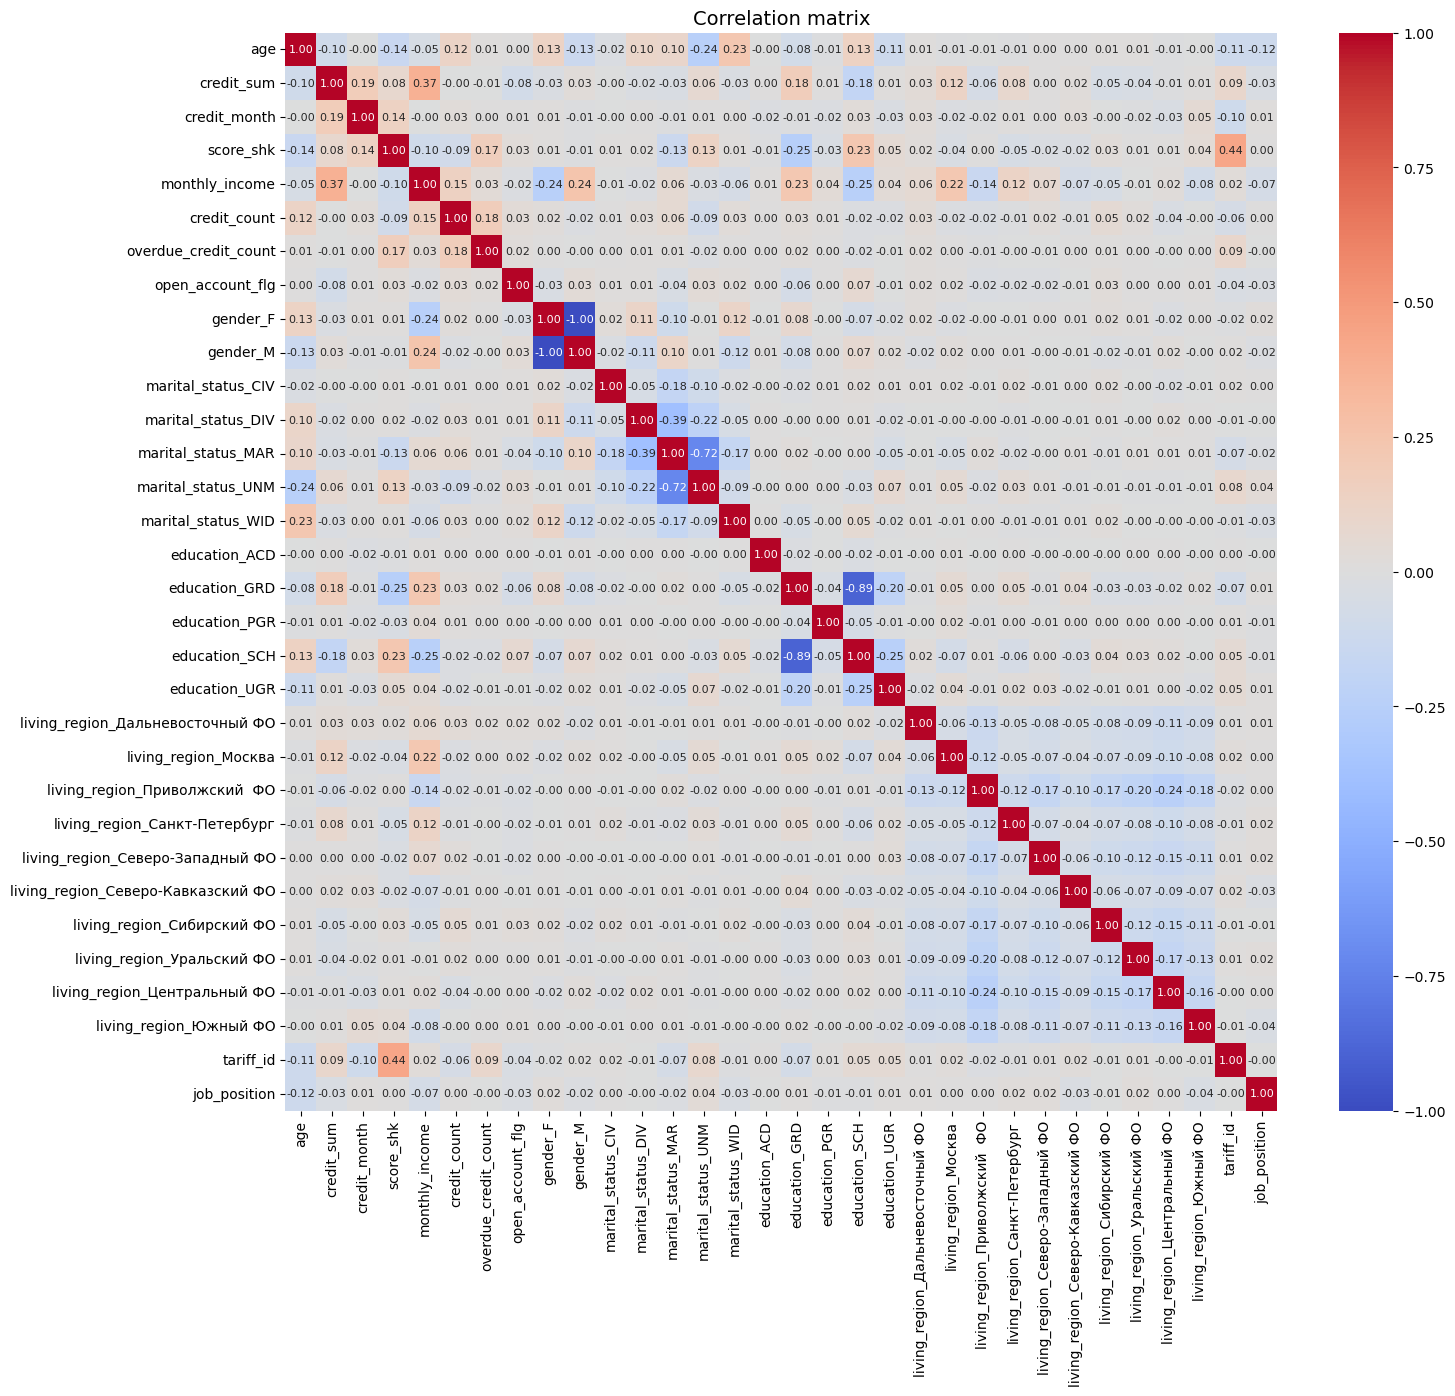

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

# picking the numeric columns only: 
# corr = data_table_encoded[numerical_features].corr()
# using all the columns:
corr = data_table_encoded.corr()
plt.figure(figsize=(16, 14))
sns.heatmap(corr, fmt='.2f', annot = True, cmap = 'coolwarm', annot_kws={"fontsize":8}) # cmap: 'seismic', 'coolwarm', YlGnBu", "Blues", "coolwarm", "BuPu", "Greens", "Oranges", "Reds", "Purples", "YlOrBr"
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.title("Correlation matrix", fontsize = 14)
plt.savefig('CorrMatrix.png') 
plt.show()

Из корреляционной матрицы намечается:
Положительная корреляция между суммой кредита и месячным доходом.
Отрицательная корреляция между возрастом и статусом "не в браке".
Положительная корреляция между возрастом и статусом "вдовство".
Положительная корреляция между суммой и сроком кредита.
Отрицательная корреляция между числом взятых кредитов и кредитным рейтингом гражданина.
У месячного дохода есть положительная корреляция с мужским полом и такая же отрицательная корреляция с женским полом.
Видна также корреляция между id тарифа и кредитным рейтингом.
Сильная корреляция наблюдается в парах априорно взаимоисключающих статусов, например "в браке" - "не в браке", "образование школьное" - "образование базовое".
Что касается регионов, то намечается положительная корреляция между месячным доходом и проживанием в Москве, и гораздо слабее - с проживанием в Петербурге.
Впрочем, в целом коэффициенты корреляции не настолько велики, чтобы можно было на них опираться.

Тест на нормальность распределения.
Проверка с помощью теста Шапиро-Вилка в нашем случае не годится, поскольку для N>5000 практически всегда гипотеза нормального распределения отвергается. А у нас около двухсот тысяч строк в файле.
То есть в нашем случае почти наверняка результат будет отрицательным.
Но проверить не худо:

In [7]:
from scipy.stats import shapiro
for feature in numerical_features:
    print(feature)
    # print(data_table_encoded[feature])
    s, p = shapiro(data_table_encoded[feature])
    print(f'The p-value is {p}')
    if p > 0.05:
        print(f'The null hypothesis (that the data came from a normally distributed population)\n can not be rejected for {feature}')
    else:
        print(f'There is evidence that the data in {feature} are not normally distributed')     
    

age
The p-value is 1.4009314108309716e-102
There is evidence that the data in age are not normally distributed
credit_sum
The p-value is 1.5051053010672252e-124
There is evidence that the data in credit_sum are not normally distributed
credit_month
The p-value is 1.1439403606602096e-146
There is evidence that the data in credit_month are not normally distributed
score_shk
The p-value is 3.125780018823504e-55
There is evidence that the data in score_shk are not normally distributed
monthly_income
The p-value is 5.747761300876801e-117
There is evidence that the data in monthly_income are not normally distributed
credit_count
The p-value is 2.888772789034875e-127
There is evidence that the data in credit_count are not normally distributed
overdue_credit_count
The p-value is 1.1114360372603765e-187
There is evidence that the data in overdue_credit_count are not normally distributed
open_account_flg
The p-value is 2.706085677031308e-175
There is evidence that the data in open_account_flg ar

c:\Users\User\anaconda3\Lib\site-packages\scipy\stats\_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 151034.
  res = hypotest_fun_out(*samples, **kwds)


Действительно, значения доверительной вероятности получились весьма малыми, и даже выскочило предупреждение о неприменимости теста.


Самое простое, что можно сделать - ограничить размер набора данных. Например, посчитать р-value по выборке мощностью 100 единиц.


In [8]:
for feature in numerical_features:      
    s, p = shapiro(data_table_encoded[feature][1:100])
    print(f'The p-value is {p}')
    if p > 0.05:
        print(f'The null hypothesis (that the data came from a normally distributed population) \ncan not be rejected for {feature}\n')
    else:
        print(f'There is evidence that the data in {feature} are not normally distributed\n')

The p-value is 3.229964458699841e-07
There is evidence that the data in age are not normally distributed

The p-value is 7.496645037049117e-09
There is evidence that the data in credit_sum are not normally distributed

The p-value is 8.830016403477114e-10
There is evidence that the data in credit_month are not normally distributed

The p-value is 0.20602606317416577
The null hypothesis (that the data came from a normally distributed population) 
can not be rejected for score_shk

The p-value is 0.010089691574579266
There is evidence that the data in monthly_income are not normally distributed

The p-value is 7.152098905694642e-08
There is evidence that the data in credit_count are not normally distributed

The p-value is 8.257159641601834e-21
There is evidence that the data in overdue_credit_count are not normally distributed

The p-value is 2.994975300471226e-17
There is evidence that the data in open_account_flg are not normally distributed



Видим, что для набора из 100 элементов выборки нельзя отвергнуть гипотезу о нормальном распределении данных для кредитного рейтинга (score_shk) и числа просроченных кредитов (overdue_credit_count).

Проверим выборки на нормальность с помощью текста Андерсона-Дарлинга, который должен работать для больших выборок:

In [9]:
from scipy.stats import anderson
for feature in numerical_features:  
    print(f'{feature}:')    
    res = anderson(data_table_encoded[feature], dist='norm') # Anderson-Darling test for normality of the sampled set
    # print(res)
    # print(f'Critical values: {res.critical_values}')
    # print(f'Significance_level: {res.critical_values}')
    print(f'The p-value for 5% is {res.critical_values[2]}\n')
    """if p > 0.05:
        print(f'The null hypothesis (that the data came from a normally distributed population) \ncan not be rejected for {feature}\n')
    else:
        print(f'There is evidence that the data in {feature} are not normally distributed\n')
    """    

age:
The p-value for 5% is 0.787

credit_sum:
The p-value for 5% is 0.787

credit_month:
The p-value for 5% is 0.787

score_shk:
The p-value for 5% is 0.787

monthly_income:
The p-value for 5% is 0.787

credit_count:
The p-value for 5% is 0.787

overdue_credit_count:
The p-value for 5% is 0.787

open_account_flg:
The p-value for 5% is 0.787



Далее следует масштабировать данные - то есть поделить числовые колонки на их максимумы.
В финале сохранить полученные предобработанные данные для дальнейшего использования в какой-либо модели.

In [10]:
for feature in numerical_features:
    data_table_encoded[feature] = data_table_encoded[feature] / data_table_encoded[feature].max()

data_table_encoded.to_csv('credit_train_preprocessed.csv', sep = ';', decimal = '.', encoding = 'windows-1251')  
print(data_table_encoded.shape) 

(151034, 32)


Выводы:
Проведена предобработка файла данных по кредитам.
Убраны все строки данных с пропусками.
Регионы выдачи кредитов поделены на 10 групп - Москва, Петербург, и 8 федеральных округов.
Построена матрица корреляции числовых колонок данных. 
Указания на наличие корреляции (хотя значение коэффициента корреляции недостаточно высокое, чтобы уверенно утверждать корреляцию данных) получено для следующих параметров:
Положительная корреляция между суммой кредита и месячным доходом - логично, банки дают более высокие кредиты гражданам с более высоким доходом.
Отрицательная корреляция между возрастом и статусом "не в браке" - логично, молодежь еще не повыскакивала замуж/не поженилась.
Положительная корреляция между возрастом и статусом "вдовство" - логично, все мы смертны.
Положительная корреляция между суммой и сроком кредита - логично, чем больше кредит, тем дольше его отдавать.
Отрицательная корреляция между числом взятых кредитов и кредитным рейтингом гражданина - тоже логично, кредитный рейтинг опирается на число уже взятых кредитов.
У месячного дохода есть положительная корреляция с мужским полом и такая же отрицательная корреляция с женским полом, что логично, учитывая гендерное неравенство.
Видна также корреляция между id тарифа и кредитным рейтингом, скорее всего обусловленная тем, что именно кредитный рейтинг служит источником для присвоения того или иного тарифа.
Также сильная корреляция наблюдается в парах априорно взаимоисключающих статусов, например "в браке" - "не в браке", "образование школьное" - "образование базовое", которая, конечно, не несет полезной информации.
Что касается регионов, то намечается положительная корреляция между месячным доходом и проживанием в Москве, и гораздо слабее - с проживанием в Петербурге.

Были убраны выбросы и проведена нормировка данных.

Мы получили, что обработанный файл стал гораздо больше исходного, несмотря на то, что множество строк с данными было отсеяно из-за неполноты или плохого качества данных (изначально файл содержал 170 тысяч строк, теперь 143 тысячи строк). В первую очередь распухание файла данных обусловлено использованием OneHotEncoder, который для каждого значения категориальных данных создает свою колонку с бинарными значениями, отчего в предобработанном файле оказывается гораздо больше колонок, чем в исходном.
